# Instructions
<strong>DRILL: Improve this gradient boost model</strong>

While this model is already doing all right (about 0.75 accuracy), we've seen from the Type I and Type II error rates that there is definitely room for improvement. Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set. Strategies you might use include:

- Creating new features
- Applying more overfitting-prevention strategies like subsampling
- More iterations
- Trying a different loss function
- Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

In [134]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Load and clean

In [136]:
raw_df = pd.read_csv(
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")
print(raw_df.shape)
raw_df.head()

(8594, 13)


,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


Let's check our nulls and our country counts:

In [269]:
raw_df.isnull().sum()

cntry        0
idno         0
year         0
tvtot        8
ppltrst     14
pplfair     39
pplhlp      25
happy       31
sclmeet     15
sclact      94
gndr        10
agea       239
partner     17
dtype: int64

In [270]:
raw_df.cntry.value_counts()

ES    2426
SE    1816
CH    1546
NO    1462
CZ    1316
DE      28
Name: cntry, dtype: int64

In [138]:
# Nulls: Dropping a couple hundred out of 8600 rows is no biggie.  
# Let's drop those - and the unnecessary ID number and year columns, while we're at it.
happiness_df = raw_df.dropna().copy()
happiness_df.drop(['idno', 'year'], axis=1, inplace=True)

# And let's convert partner to a Boolean rather than 1 or 2.
happiness_df['partner'] = happiness_df['partner']==1.0

# Because we've got just 28 people from Germany (compared to at least 1200 from every other country here) 
# let's drop Germany.
happiness_df = happiness_df[happiness_df['cntry']!='DE']

# Let's make gender a -1 / +1 binary (useful for multiplying columns for feature generation later):
happiness_df['gndr'] = (happiness_df['gndr']*2 - 3).astype(int)

# And we'll convert our countries into dummy variables later, when we do our train/test splits.
happiness_df.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1,60.0,True
1,CH,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1,59.0,True
2,CH,1.0,8.0,8.0,8.0,7.0,6.0,3.0,-1,24.0,False
3,CH,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1,64.0,True
4,CH,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1,55.0,True


# Preliminary RF and boosted RT models

In [142]:
from sklearn.model_selection import train_test_split
X = pd.get_dummies(happiness_df.drop('partner', axis=1), columns=['cntry'])
y = happiness_df['partner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [140]:
from sklearn.metrics import confusion_matrix
def show_conf_mat(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.figure(figsize=(5,5))
    conf_mat = np.round(confusion_matrix(y_test, y_pred)/len(y_test), 2)
    sns.heatmap(conf_mat, square=True, annot=True, annot_kws={'size':16}, cmap='RdBu_r', center=0, fmt='g')
    plt.title('confusion matrix (by percentage)')
    plt.show()

First, a basic random forest, aka random tree + bagging:

[0.6971935  0.68423645 0.69704433 0.69837358] 
 mean:  0.6942119679904318


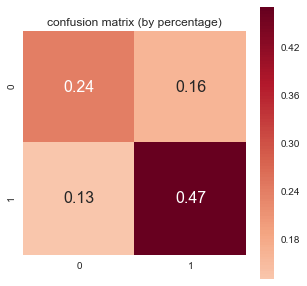

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

rfc = RandomForestClassifier()
cv_score = cross_val_score(rfc, X, y, cv=4)
print(cv_score, '\n mean: ', np.mean(cv_score))

show_conf_mat(rfc)

Not bad.  And now for a basic RT + boosting model with Thinkful's initial settings:

CV scores: [0.73855244 0.72413793 0.75123153 0.7353376 ] 
 mean:  0.7373148750206291
Train score:  0.8105090311986863
Test score:  0.7438423645320197


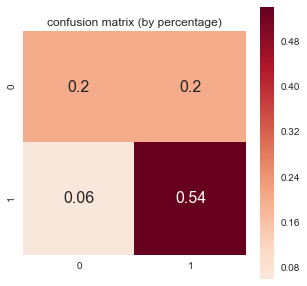

In [130]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
          'random_state': 11}

gbc_1 = ensemble.GradientBoostingClassifier(**params)
cv_score = cross_val_score(gbc_1, X, y, cv=4)
gbc_1.fit(X_train, y_train)
train_score = gbc_1.score(X_train, y_train)
test_score = gbc_1.score(X_test, y_test)

print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

show_conf_mat(gbc_1)

This is better, though not by a huge margin.  If we tinker with the parameters a bit (I've omitted the tinkering for sake of space), we see that we tend to overfit if we increase the depth of the trees.  Doubling or quadrupling the number of trees/estimators also leads to overfitting (albeit not as severe) with no true accuracy improvement.  One example of an improvement in speed and accuracy by lowering the number of trees:

In [143]:
params = {'n_estimators': 100,
          'max_depth': 2,
          'loss': 'deviance',
          'random_state': 11}

gbc_1 = ensemble.GradientBoostingClassifier(**params)
cv_score = cross_val_score(gbc_1, X, y, cv=4)
gbc_1.fit(X_train, y_train)
train_score = gbc_1.score(X_train, y_train)
test_score = gbc_1.score(X_test, y_test)

print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

CV scores: [0.76070901 0.74729064 0.74334975 0.73977329] 
 mean:  0.7477806729405164
Train score:  0.7658456486042693
Test score:  0.7433497536945812


So for now, 0.755 is the score to beat.  Let's what a hyperparamter search can get us:

In [147]:
# report utility function from http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [148]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
param_dist = {
    'loss': ['deviance','exponential'],
    'n_estimators': [100], # we'll change this next time
    'learning_rate': [0.1], # ditto
    'max_depth': [2,4,6,8],
    'max_features': [2,4,6,8],
    'subsample': [0.1, 0.3, 0.6, 1],
    'random_state': [11]
}

random_search = RandomizedSearchCV(gbc_1, param_distributions=param_dist, n_iter=25)
start = time()
random_search.fit(X_train, y_train)

print("Elapsed seconds: ", time()-start)
report(random_search.cv_results_, n_top=3)

Elapsed seconds:  38.68736410140991
Model with rank: 1
Mean validation score: 0.759 (std: 0.005)
Parameters: {'subsample': 1, 'random_state': 11, 'n_estimators': 100, 'max_features': 6, 'max_depth': 2, 'loss': 'exponential', 'learning_rate': 0.1}

Model with rank: 2
Mean validation score: 0.757 (std: 0.001)
Parameters: {'subsample': 0.6, 'random_state': 11, 'n_estimators': 100, 'max_features': 6, 'max_depth': 4, 'loss': 'deviance', 'learning_rate': 0.1}

Model with rank: 3
Mean validation score: 0.757 (std: 0.005)
Parameters: {'subsample': 0.6, 'random_state': 11, 'n_estimators': 100, 'max_features': 6, 'max_depth': 2, 'loss': 'deviance', 'learning_rate': 0.1}

Model with rank: 3
Mean validation score: 0.757 (std: 0.000)
Parameters: {'subsample': 1, 'random_state': 11, 'n_estimators': 100, 'max_features': 2, 'max_depth': 4, 'loss': 'exponential', 'learning_rate': 0.1}



This is an improvement, but only a very slight one: 0.755 to 0.759.  Now we'll do the hyperparamter sweep for number of trees and learning rate, restricting the other parameters to the optimum values found above.

In [149]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
param_dist = {
    'loss': ['deviance','exponential'],
    'n_estimators': [50,100,200,500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2,4],
    'max_features': [6],
    'subsample': [0.6, 1],
    'random_state': [11]
}

random_search = RandomizedSearchCV(gbc_1, param_distributions=param_dist, n_iter=25)
start = time()
random_search.fit(X_train, y_train)

print("Elapsed seconds: ", time()-start)
report(random_search.cv_results_, n_top=3)

Elapsed seconds:  39.6924090385437
Model with rank: 1
Mean validation score: 0.758 (std: 0.002)
Parameters: {'subsample': 1, 'random_state': 11, 'n_estimators': 500, 'max_features': 6, 'max_depth': 4, 'loss': 'deviance', 'learning_rate': 0.01}

Model with rank: 2
Mean validation score: 0.758 (std: 0.001)
Parameters: {'subsample': 0.6, 'random_state': 11, 'n_estimators': 500, 'max_features': 6, 'max_depth': 2, 'loss': 'deviance', 'learning_rate': 0.05}

Model with rank: 3
Mean validation score: 0.757 (std: 0.001)
Parameters: {'subsample': 0.6, 'random_state': 11, 'n_estimators': 50, 'max_features': 6, 'max_depth': 4, 'loss': 'exponential', 'learning_rate': 0.1}



In short, it looks like toggling the parameters makes only a small difference here. Our accuracy starts at 0.74 and maxes out around 0.76.  For now, we'll save the best parameters for later use.

In [150]:
best_params = {'subsample': 1, 
               'random_state': 11, 
               'n_estimators': 100, 
               'max_features': 6, 
               'max_depth': 2, 
               'loss': 'exponential', 
               'learning_rate': 0.1}

Finally, a quick look at AdaBoost:

CV scores: [0.75824717 0.73596059 0.7364532  0.74420897] 
 mean:  0.7437174829804253
Train score:  0.755008210180624
Test score:  0.7453201970443349


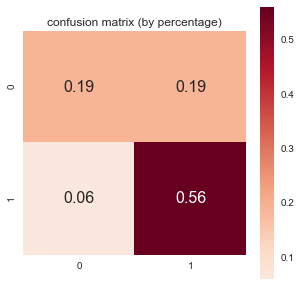

In [290]:
from sklearn.ensemble import AdaBoostClassifier

ada = ensemble.AdaBoostClassifier()
cv_score = cross_val_score(ada, X, y, cv=4)
ada.fit(X_train, y_train)
train_score = ada.score(X_train, y_train)
test_score = ada.score(X_test, y_test)

print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

show_conf_mat(ada)

Basically the same results as our initial Gradient Boost run - so we could probably get close to our top Gradient Boost accuracy with some tuning.  But basically, we're stuck at 0.76 accuracy no matter what we do with this data as it is. 

Let's try some feature engineering.

# Feature engineering

As an experiment here, I'm going to generate several new dataframes of featuresets to try running our models on.  The basic strategy will be:
- generate a bunch of relative, combinatoric, and/or polynomial features
- shrink featureset by selecting top feature_importances, and by running PCA
- test full datasets, top feature_importance datasets, and PCA datasets
- pick top performing dataset

The generated datasets are as follows:
- <b>happiness_df</b>: the original features
- <b>relative_df</b>: all of the original features scaled to the means of their respective countries
- <b>combo_df</b>: the original features plus all combinations of original features
- <b>combo_2_df</b>: the original features plus squared features plus all combinations
- <b>rel_combo_df</b>: the country-mean-scaled features plus all combinations of original features
- <b>rel_combo_2_df</b>: the country-mean-scaled features plus squared features plus all combinations

The PCA datasets will have to be generated separately post-train-test-split since PCA should only be fit to the training data.

In [151]:
# a little function to quickly construct boosted trees off a dataset and print the results
def test_data(df, has_cntry=True):
    start = time()
    if has_cntry:
        X = pd.get_dummies(df, columns=['cntry'])
    else:
        X = df
    y = happiness_df['partner']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    gbc = ensemble.GradientBoostingClassifier(**best_params)
    # cv_score = cross_val_score(gbc, X, y, cv=4)
    gbc.fit(X_train, y_train)
    train_score = gbc.score(X_train, y_train)
    test_score = gbc.score(X_test, y_test)

    # print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
    print("Train score: ", train_score)
    print("Test score: ", test_score)
    print("Elapsed time (seconds): ", time()-start)

In [57]:
happiness_df.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1,60.0,True
1,CH,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1,59.0,True
2,CH,1.0,8.0,8.0,8.0,7.0,6.0,3.0,-1,24.0,False
3,CH,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1,64.0,True
4,CH,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1,55.0,True


In [152]:
relative_df = happiness_df.copy()
for col_name in relative_df.columns[1:10]: # excludes country, partner
    cntry_means = relative_df.groupby('cntry')[col_name].agg(np.mean)
    cntry_means_col = [cntry_means[cntry] for cntry in relative_df['cntry']]
    relative_df[col_name] = relative_df[col_name] / cntry_means_col

In [153]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only=True, include_bias=False)
combo_df = pd.DataFrame(poly.fit_transform(happiness_df.drop(['cntry', 'partner'], axis=1)))
combo_df['cntry'] = happiness_df['cntry'].copy()

In [154]:
poly = PolynomialFeatures(degree=2,include_bias=False,interaction_only=False)
combo_2_df = pd.DataFrame(poly.fit_transform(happiness_df.drop(['cntry', 'partner'], axis=1)))
combo_2_df['cntry'] = happiness_df['cntry'].copy()

In [155]:
poly = PolynomialFeatures(degree=2,interaction_only=True, include_bias=False)
rel_combo_df = pd.DataFrame(poly.fit_transform(relative_df.drop(['cntry', 'partner'], axis=1)))
rel_combo_df['cntry'] = happiness_df['cntry'].copy()

In [156]:
poly = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
rel_combo_2_df = pd.DataFrame(poly.fit_transform(relative_df.drop(['cntry', 'partner'], axis=1)))
rel_combo_2_df['cntry'] = happiness_df['cntry'].copy()

In [157]:
print("*********\n Unmodified data: ")
test_data(happiness_df.drop('partner', axis=1))
print("*********\n Relative data: ")
test_data(relative_df.drop('partner', axis=1))
print("*********\n Feature-combined data: ")
test_data(combo_df)
print("*********\n Feature-combined + squared data: ")
test_data(combo_2_df)
print("*********\n Relative feature-combined data: ")
test_data(rel_combo_df)
print("*********\n Relative feature-combined + squared data: ")
test_data(rel_combo_2_df)
print("*********\n Relative feature-combined + squared data w/out country: ")
test_data(rel_combo_2_df.drop('cntry', axis=1), has_cntry=False)

*********
 Unmodified data: 
Train score:  0.7582922824302135
Test score:  0.7497536945812808
Elapsed time (seconds):  0.2036888599395752
*********
 Relative data: 
Train score:  0.7614121510673235
Test score:  0.7438423645320197
Elapsed time (seconds):  0.19133329391479492
*********
 Feature-combined data: 
Train score:  0.7648604269293925
Test score:  0.7591133004926108
Elapsed time (seconds):  0.2402801513671875
*********
 Feature-combined + squared data: 
Train score:  0.7633825944170771
Test score:  0.7527093596059113
Elapsed time (seconds):  0.2300570011138916
*********
 Relative feature-combined data: 
Train score:  0.7660098522167488
Test score:  0.7467980295566502
Elapsed time (seconds):  0.26165103912353516
*********
 Relative feature-combined + squared data: 
Train score:  0.7609195402298851
Test score:  0.7605911330049261
Elapsed time (seconds):  0.2676119804382324
*********
 Relative feature-combined + squared data w/out country: 
Train score:  0.7666666666666667
Test scor

Wow - we're still thoroughly stuck at the same level as the original, unmodified data.

Let's see if we can get some feature importance info here:

In [164]:
X = pd.get_dummies(rel_combo_2_df, columns=['cntry'])
y = happiness_df['partner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

gbc_5 = ensemble.GradientBoostingClassifier(**best_params)
gbc_5.fit(X_train, y_train)
train_score = gbc_5.score(X_train, y_train)
test_score = gbc_5.score(X_test, y_test)

print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.7676518883415435
Test score:  0.7502463054187192


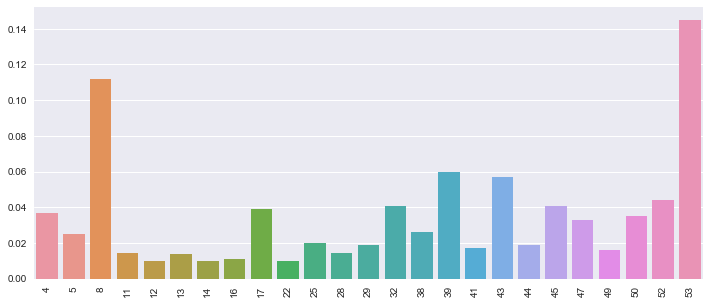

In [166]:
labeled_fi = sorted( list(zip(X_train.columns, gbc_5.feature_importances_)), key=lambda x: -x[1])
plt.figure(figsize=(12,5))
x_imp = [tup[0] for tup in labeled_fi[:25]]
y_labels = [tup[1] for tup in labeled_fi[:25]]
plt.xticks(rotation=90)
sns.barplot(x_imp, y_labels);

In [172]:
labeled_fi[:10]

[(53, 0.14509901706791667),
 (8, 0.11206288696780442),
 (39, 0.05992083123997044),
 (43, 0.05720184297979336),
 (52, 0.044145187926058344),
 (32, 0.04083626840627251),
 (45, 0.040413322453058106),
 (17, 0.03900616669303408),
 (4, 0.03671893172787829),
 (50, 0.03480580616982972)]

Bafflingly, this isn't graphing as sorted, even though it in fact sorted (see above).  ????  At any rate, it's of no interpretational use because the labels produced by sklearn's combination algorithm are totally uninformative. 

We could try taking the top 10 features and running the algorithm with only those:

In [203]:
col_nums = [tup[0] for tup in labeled_fi[:10]]
X = pd.get_dummies(rel_combo_2_df, columns=['cntry']).iloc[:, col_nums]
y = happiness_df['partner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

gbc_5 = ensemble.GradientBoostingClassifier(**best_params)
gbc_5.fit(X_train, y_train)
train_score = gbc_5.score(X_train, y_train)
test_score = gbc_5.score(X_test, y_test)

print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.7614121510673235
Test score:  0.7541871921182266


Not much difference here - it's less accurate, but very slightly.  Now let's try PCA - first with a regularized version of our combination squared featureset:

In [204]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform ( pd.get_dummies(combo_2_df, columns=['cntry']) )
X_train, X_test, y_train, y_test = train_test_split(X, happiness_df['partner'], test_size=0.25)
pca = PCA(n_components=20)
pca.fit(X_train)
Xpc_train = pca.transform(X_train)
Xpc_test = pca.transform(X_test)

In [210]:
gbc_pca = ensemble.GradientBoostingClassifier(**best_params)
# cv_score = cross_val_score(gbc_pca, X, y, cv=4)
gbc_pca.fit(Xpc_train, y_train)
train_score = gbc_pca.score(Xpc_train, y_train)
test_score = gbc_pca.score(Xpc_test, y_test)

# print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.7431855500821019
Test score:  0.7216748768472906


Interesting: it's a fair bit worse.  And how about PCA with the *unregularized* combination squared featureset:

In [211]:
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(combo_2_df, columns=['cntry']), happiness_df['partner'], test_size=0.25)
pca = PCA(n_components=20)
pca.fit(X_train)
Xpc_train = pca.transform(X_train)
Xpc_test = pca.transform(X_test)

In [212]:
gbc_pca = ensemble.GradientBoostingClassifier(**best_params)
# cv_score = cross_val_score(gbc_pca, X, y, cv=4)
gbc_pca.fit(Xpc_train, y_train)
train_score = gbc_pca.score(Xpc_train, y_train)
test_score = gbc_pca.score(Xpc_test, y_test)

# print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.770607553366174
Test score:  0.7497536945812808


Oddly, this score is significantly better than the PCA-version of the regularized dataset (though still worse than the original data).

Finally, PCA with unregularized *relative* combo squared featureset:

In [216]:
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(rel_combo_2_df, columns=['cntry']), happiness_df['partner'], test_size=0.25)
pca = PCA(n_components=12)
pca.fit(X_train)
Xpc_train = pca.transform(X_train)
Xpc_test = pca.transform(X_test)

gbc_pca = ensemble.GradientBoostingClassifier(**best_params)
# cv_score = cross_val_score(gbc_pca, X, y, cv=4)
gbc_pca.fit(Xpc_train, y_train)
train_score = gbc_pca.score(Xpc_train, y_train)
test_score = gbc_pca.score(Xpc_test, y_test)

# print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.7126436781609196
Test score:  0.7044334975369458


Definitely not a winner.

It seems to me (for reasons explained in the conclusion below) that feature engineering may be pretty much useless for random forests and boosted trees, because they already account for variable interaction and aren't constricted to linear boundaries.  To test this, let's try running logistic regression on these datasets.  My hypothesis is that properly regularized logistic regression will produce better results with the expanded (engineered) datasets.

In [222]:
from sklearn.linear_model import LogisticRegression

def test_lreg_data(df, has_cntry=True):
    start = time()
    if has_cntry:
        X = pd.get_dummies(df, columns=['cntry'])
    else:
        X = df
    y = happiness_df['partner']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    lreg = LogisticRegression(penalty='l1')
    lreg.fit(X_train, y_train)
    train_score = lreg.score(X_train, y_train)
    test_score = lreg.score(X_test, y_test)

    print("Train score: ", train_score)
    print("Test score: ", test_score)
    print("Elapsed time (seconds): ", time()-start)

In [223]:
print("*********\n Unmodified data: ")
test_lreg_data(happiness_df.drop('partner', axis=1))
print("*********\n Relative data: ")
test_lreg_data(relative_df.drop('partner', axis=1))
print("*********\n Feature-combined data: ")
test_lreg_data(combo_df)
print("*********\n Feature-combined + squared data: ")
test_lreg_data(combo_2_df)
print("*********\n Relative feature-combined data: ")
test_lreg_data(rel_combo_df)
print("*********\n Relative feature-combined + squared data: ")
test_lreg_data(rel_combo_2_df)
print("*********\n Relative feature-combined + squared data w/out country: ")
test_lreg_data(rel_combo_2_df.drop('cntry', axis=1), has_cntry=False)

*********
 Unmodified data: 
Train score:  0.6990147783251232
Test score:  0.7187192118226601
Elapsed time (seconds):  0.11037683486938477
*********
 Relative data: 
Train score:  0.7106732348111658
Test score:  0.6975369458128079
Elapsed time (seconds):  0.11685824394226074
*********
 Feature-combined data: 
Train score:  0.7236453201970443
Test score:  0.7078817733990148
Elapsed time (seconds):  1.8555629253387451
*********
 Feature-combined + squared data: 
Train score:  0.7568144499178981
Test score:  0.7482758620689656
Elapsed time (seconds):  2.9031522274017334
*********
 Relative feature-combined data: 
Train score:  0.7152709359605911
Test score:  0.7182266009852217
Elapsed time (seconds):  0.9342520236968994
*********
 Relative feature-combined + squared data: 
Train score:  0.7403940886699507
Test score:  0.758128078817734
Elapsed time (seconds):  0.19919514656066895
*********
 Relative feature-combined + squared data w/out country: 
Train score:  0.7490968801313629
Test scor

My hypothesis is basically true: we get a bump of about four percentage points in our accuracy by feature engineering.  It's not an enormous difference, but it's significant - whereas the data changes didn't even move us one percentage point on the boosting model.

# Conclusion:

A summary of what I've tried:
- a hyperparameter sweep of all the main parameters of Gradient Boost
- all possible two-variable combinations of the data
- squaring all variables in the data
- normalizing all data columns to the individual's country's averages
- running PCA on both regularized and unregularized versions of the maximal dataset.

All of these methods produced between 0.70 and 0.76 accuracy.  My improvement on Thinkful's initial settings was 1.5, from 0.744 to 0.759.  This improvement was all based on parameter tweaking; feature engineering made no significant difference.

I was expecting larger gains, and I have no idea how to use the data here to get a better accuracy than 0.76.  It seems that nearly any form of random forest or boosted forest will get you at least 0.72, but no amount of feature engineering or algorithm tweaking will get you beyond 0.76.  It's possible, I suppose, that 24% of the "partner" variable is just noise unrelated to any of the data here, in which case we've hit the hard ceiling.  However, that would be exceptionally mean for Thinkful to do (since that's the initial accuracy they achieved and told us to improve on), so I'm hopeful that I'm missing something here.

One tentative conclusion here - which would be very useful to know, if true - is that random forests and gradient boosted trees already capture all inter-feature relationships, so adding combined features won't make any substantial difference.  They also aren't linearly constrained, so it's not totally clear that adding polynomial features will do much good either.  Which begs the question: is feature engineering theoretically irrelevant for these models?  (which would make it odd that Thinkful recommended we try it...)

One question I have is why regularization actually made PCA produce less useful components.

Finally, the obvious quasi-cheat here (and the only way I can think of to improve on this) is to insert some relevant data about the countries - average marriage age, for instance - and see if that helps.  But presumably much of that effect should already be captured in the algorithm's treatment of the country column.

# One other question based on an early attempt here:

In [228]:
# for col_name in happiness_df.columns[1:10]: # excludes country, partner
#     cntry_means = happiness_df.groupby('cntry')[col_name].agg(np.mean)
#     happiness_df['relative_'+col_name] = happiness_df[col_name] / cntry_means[happiness_df['cntry']]
# FIXED THIS BELOW BY GENERATING A NEW LIST but it's odd that the indexing doesn't allow it - I don't know why.

# First, every score is probably more important relative to fellow citizens than to other EU countries
# (what makes us happy is sometimes not what we have, but what we have compared to the Joneses)
for col_name in happiness_df.columns[1:10]: # excludes country, partner
    cntry_means = happiness_df.groupby('cntry')[col_name].agg(np.mean)
    cntry_means_col = [cntry_means[cntry] for cntry in happiness_df['cntry']]
    happiness_df['relative_'+col_name] = happiness_df[col_name] / cntry_means_col

# tvtot may be different based on happiness, and based on social interactions
happy_scaled = (happiness_df['happy'] - np.mean(happiness_df.happy)) / 10
sclmeet_scaled = (happiness_df['sclmeet'] - np.mean(happiness_df.sclmeet)) / 10
happiness_df['tv_happ'] = happiness_df['tvtot'] * happy_scaled
happiness_df['tv_soc'] = happiness_df['tvtot'] * sclmeet_scaled

# age and happiness are likely to have a significant interaction - older singles are probably less likely
# to be happy single than people in their 20s
happiness_df['age_happ'] = (happiness_df['agea'] - np.mean(happiness_df.agea)) * happiness_df.happy

# finally, number of social activities interacting with gender and age may predict partner
# note: subtracting 1.5 from gndr makes it a binary -0.5 and 0.5
happiness_df['gender_sclact'] = (happiness_df['gndr'] * happiness_df['sclact']) 
# multiply 

# and finally, let's try correlating gender with all other features
happiness_df.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,...,relative_pplhlp,relative_happy,relative_sclmeet,relative_sclact,relative_gndr,relative_agea,tv_happ,tv_soc,age_happ,gender_sclact
0,CH,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1,60.0,...,0.879442,0.986045,0.970906,1.455712,44.69697,1.285683,0.087340,-0.065320,102.160591,4.0
1,CH,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1,59.0,...,0.879442,1.109301,0.582543,0.727856,44.69697,1.264255,0.774680,-1.330640,105.930665,2.0
2,CH,1.0,8.0,8.0,8.0,7.0,6.0,3.0,-1,24.0,...,1.407107,0.862789,1.165087,1.091784,-44.69697,0.514273,-0.070887,0.078227,-162.609483,-3.0
3,CH,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1,64.0,...,1.231219,1.232556,1.165087,0.727856,44.69697,1.371395,0.916453,0.312906,167.700739,2.0
4,CH,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1,55.0,...,0.879442,0.986045,1.359268,0.727856,44.69697,1.178543,0.145567,0.891133,62.160591,2.0


Now let's winnow them down using feature importance testing:

In [255]:
X = pd.get_dummies(happiness_df.drop('partner', axis=1), columns=['cntry'])
y = happiness_df['partner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Train score:  0.8853858784893268 
Test score:  0.7527093596059113


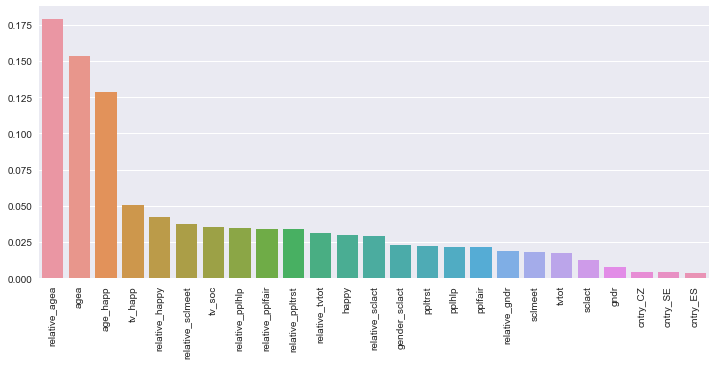

In [256]:
rfc_2 = RandomForestClassifier(n_estimators=100, max_depth=12)
rfc_2.fit(X_train, y_train)
train_score = rfc_2.score(X_train, y_train)
test_score = rfc_2.score(X_test, y_test)
print("Train score: ", train_score, "\nTest score: ", test_score)
labeled_fi = sorted( list(zip(X_train.columns, rfc_2.feature_importances_)), key=lambda x: -x[1])
plt.figure(figsize=(12,5))
x_imp = [tup[0] for tup in labeled_fi[:25]]
y_labels = [tup[1] for tup in labeled_fi[:25]]
plt.xticks(rotation=90)
sns.barplot(x_imp, y_labels);

On an initial look, it seems we've got more overfitting but no more accuracy.  What's surprising here to me is that there's no accuracy gain even though nine of the ten most important features are engineered features.  I would think that generating new features more predictively important than the old features would entail an accuracy gain.  Why doesn't it?